# Импорты и классы

In [314]:
import os
import matplotlib.pyplot as plt

os.environ['DEVICE'] = 'cpu'
os.environ['PATH_MODELS'] = '/home/daniil/project/PageR/models/'
os.environ["JAR_PDF_PARSER"] = '/home/daniil/project/PageR/models/PDF2Block/precisionPDF.jar'
from pager import PDFModel, RegionModel, RowsModel, PDF2Words, PDF2Rows, ImageModel, PDF2Img

import numpy as np
from pager.page_model.sub_models.dtype import ImageSegment 
from pager.page_model.sub_models.phisical_model.segment_clusterizer import KMeanClusterizer
from pager.page_model.sub_models import BaseConverter
from pager.page_model.sub_models.dtype import Graph
import re
import torch
from torch.nn import Linear, BCELoss, BCEWithLogitsLoss, CrossEntropyLoss, GELU, HuberLoss,ModuleList
from torch.nn.functional import relu
from torch_geometric.nn import BatchNorm, TAGConv
from typing import List

from json import JSONEncoder  
from torch.utils.data import Dataset 
import json
import torch
import os

from torch.utils.data import Dataset 
import json

import time
import os
import numpy as np
import datetime
import matplotlib.pyplot as plt
device = 'cpu'

dataset_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/train'
test_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/dev'
test_coco_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/publaynet/val.json'
coco_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/publaynet/train.json'
cash_path = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/tmp/jsons_regions'

SAVE_FREQUENCY = 5
LOG_FILE = 'log.txt'
GLAM_MODEL = 'row2region_GLAM'
PARAMS  = {
    "node_featch": 15,
    "edge_featch": 4,
    "epochs": 20,
    "batch_size": 50,
    "learning_rate": 0.05,
    "Tag":[ {'in': -1, 'size': 64, 'out': 64, 'k': 3},
            {'in': 64, 'size': 32, 'out': 32, 'k': 2},
            {'in': 32, 'size': 16, 'out': 16, 'k': 1},
            ],
    "NodeLinear": [-1, 32, 16],
    # "NodeLinearClassifier": [8],
    "EdgeLinear": [32, 16, 8],
    # "NodeClasses": 5,
    "batchNormNode": True,
    "batchNormEdge": True,
    "seg_k": 0.5,
    "loss_params": {
        # "publaynet_imbalance": [0.2, 0.2, 0.2, 0.2, 0.2],
        "edge_imbalance": 1.87,
        "edge_coef": 1,
        # "node_coef": 0,
    },
    "sigmoidEdge": False
}

## Токенизатор

In [197]:
def graph_creat(segments):
    def fun_dist_bottom(seg1: ImageSegment, seg: ImageSegment):
        b = seg1.y_bottom_right
        t = seg.y_top_left
        if seg1.x_bottom_right < seg.x_top_left or seg.x_bottom_right < seg1.x_top_left:
            return np.inf
        if b >= t:
            return np.inf
        return t - b

    def fun_dist_right(seg1: ImageSegment, seg: ImageSegment):
        r = seg1.x_bottom_right
        l = seg.x_top_left

        _, y1c = seg1.get_center()
        _, yc = seg.get_center()
        h = (seg1.height + seg.height)/2        
        if seg1.y_bottom_right - seg.y_top_left >  3*h or seg.y_bottom_right - seg1.y_top_left > 3*h:
            return np.inf
        if r >= l:
            return np.inf
        return abs(l - r)+5*abs(y1c-yc)

    dists_bottom = []
    for j, seg1 in enumerate(segments):
        dist_bottom = [fun_dist_bottom(seg1, seg) for seg in segments]
        if min(dist_bottom) == np.inf:
            continue
        k = int(np.argmin(dist_bottom))
        dists_bottom.append((j, k))

    # dists_top = [(k, j) for j, k in dists_bottom]

    dists_right = []
    for j, seg1 in enumerate(segments):
        dist_right = [fun_dist_right(seg1, seg) for seg in segments]
        if min(dist_right) == np.inf:
            continue
        k = int(np.argmin(dist_right))
        dists_right.append((j, k))

    # dists_left = [(k, j) for j, k in dists_right]

    all_edges = dists_bottom + dists_right
    return all_edges

class RowGLAMTokenizer:
    def __call__(self, rows_json):
        A = self.get_A(rows_json)
        node_features = self.get_node_features(rows_json)
        edge_features = self.get_edge_features(A, rows_json)
        json_info =  {
            'A': A,
            'node_features': node_features,
            'edge_features': edge_features
        }
        return self.get_tensor_from_graph(json_info)

    def get_A(self, rows_json):
        
        edges = graph_creat([ImageSegment(dict_2p=row_json['segment']) for row_json in rows_json])

        A1, A2 = [], []
        for a1, a2 in edges:
            A1.append(a1)
            A2.append(a2)
        index = np.argsort(A1)
        A1_ = [A1[i] for i in index]
        A2_ = [A2[i] for i in index]
    
        return [A1_, A2_]
    
    def get_node_features(self, rows_json):
        if len(rows_json) == 0:
            return [[]]
        rows_texts = [r['text'] for r in rows_json]
        dot_vec = np.array([[1.0 if dot in r else 0.0 for dot in (".", ",", ";", ":")] for r in rows_texts])
        
        list_ind_vec = np.array([self.get_vec_list(r) for r in rows_texts])
        super_vec = np.array([self.get_vec_supper(r) for r in rows_texts])
        coord_vec = np.array([self.get_vec_coord(r_json) for r_json in rows_json])
        heuristics_vec = np.array([self.get_vec_heuristics(r_json) for r_json in rows_json])
        nodes_feature = np.concat([coord_vec,  dot_vec, super_vec, list_ind_vec, heuristics_vec], axis=1)
        return nodes_feature.tolist()

    def get_edge_features(self, A, rows_json):
        edges_featch = []
        for i, j in zip(A[0], A[1]):
            r1 = ImageSegment(dict_2p= rows_json[i]['segment'])
            r2 = ImageSegment(dict_2p= rows_json[j]['segment'])
            x1, y1 = r1.get_center()
            x2, y2 = r2.get_center()

            edges_featch.append([r1.get_angle_center(r2), r1.get_min_dist(r2), abs(x1-x2), abs(y1-y2)])
        # print(edges_featch)
        return edges_featch
    
    def get_tensor_from_graph(self, graph):
        i = graph["A"]
        v_in = [1 for e in graph["edge_features"]]
        y = graph["edge_features"]
        # for yi in y:
        #     yi[0] = 1.0 if yi[0] > 0.86 else 0.0
        x = graph["node_features"]
        N = len(x)
        
        X = torch.tensor(data=x, dtype=torch.float32)
        Y = torch.tensor(data=y, dtype=torch.float32)
        sp_A = torch.sparse_coo_tensor(indices=i, values=v_in, size=(N, N), dtype=torch.float32)
        
        return {
            "N": N,
            "X": X,
            "Y": Y,
            "sp_A": sp_A,
            "inds": i
        }
    
    def get_vec_heuristics(self, row):
        text = row['text']
        text_size = len(text)
        if text_size == 0:
            return [0, 0]
        seg = ImageSegment(dict_2p=row['segment'])
        m = seg.width/seg.height
        digit_count = sum(char.isdigit() for char in text)
        return [text_size/m, digit_count/text_size]

    def get_vec_supper(self, row_text):
        if row_text.isupper():
            return [1, 0]
        elif row_text and row_text[0].isupper():
            return [0, 1]
        else:
            return [0, 0]
        
    def get_vec_list(self, row_text):
        patterns = [
                r'\b(\d+[.)])\s+',  # 1) 2. 15)
                r'\b([a-zA-Z][.)])\s+',  # a) B.
                r'\b([IVXLCDM]+[.)])\s+',  # XIX. VII)
                r'\[\d+\]',  # [5]
                r'\(\d+\)',  # (3)
                r'(?:^|\s)([•▪▫○◆▶➢✓-])\s+',  # Спецсимволы: • Item, ▪ Subitem
                r'\*{1,}\s+',  # Звездочки: **
                r'\b\d+\.\d+\b',  # Многоуровневые: 1.1, 2.3.4
                r'\b\d+-\w+\)',  # Комбинированные: 1-a), 5-b.
                r'\b(?:Item|Пункт)\s+\d+:\s+',  # Явные указатели: Item 5:
                r'(?:^|\s)\u2022\s+',  # Юникод-символы: •
                r'\[[A-Z]\]',  # Буквы в скобках: [A]
                r'\b\d{2,}\.\s+',  # Номера с ведущими нулями: 01.
                r'#\d+\b',  # Хештег-нумерация: #5
                r'\b\d+\s*[-–—]\s+',  # Тире-разделители: 5 -
                r'\b\d+/\w+\b',  # Слэш-нумерация: 1/a
                r'<\d+>',  # Угловые скобки: <3>
                r'\b[A-Z]\d+\)',  # Буква+число: A1)
                r'\b(?:Step|Шаг)\s+\d+\b',  # Шаги: Step 3
                r'\d+[.)]\s*-\s+',  # Комбинированные с тире: 1). -
                r'\b[А-Яа-я]\s*[).]\s+',  # а) б. кириллица
                r'\b\d+[.:]\d+\)',  # 1:2) вложенность
                r'\d+\s*→\s+',  # 1 → со стрелкой
                r'\b\d+\.?[a-z]\b',  # Буквенные подуровни: 1a
                r'\b[A-Z]+-\d+\b'  # Код-номера: ABC-123
            ]
        flag = False
        for pattern in patterns:
            if bool(re.search(pattern, row_text, flags=re.IGNORECASE)):
                flag = True
                break
        list_mark = 1 if flag else 0
        return [list_mark]

    def get_vec_coord(self, row_json):
        seg = ImageSegment(dict_2p=row_json['segment'])
        return [seg.x_top_left, seg.x_bottom_right, seg.width, seg.y_top_left, seg.y_bottom_right, seg.height]

## Utils

In [315]:
def get_true_edges(token, rows, region_segs):
    def is_one_region(row_seg_1, row_seg_2, region_segs):
        for i, reg in enumerate(region_segs):
            if reg.is_intersection(row_seg_1):
                if reg.is_intersection(row_seg_2):
                    return 0
                else:
                    return 1
        return 1
    A = token['inds']
    true_edges = [is_one_region(rows[i].segment, rows[j].segment, region_segs) for i, j in zip(A[0], A[1])]
    return true_edges

def get_regions_from_json(coco_path):
    
    with open(coco_path, 'r') as f:
        coco = json.load(f)
    
    pdf_ann = dict() 
    
    id_2_file = {}
    for im in coco['images']:
        name = im['file_name'][:-3]+'pdf'
        img_id = im['id']
        id_2_file[img_id] = name
    
    
    
    get_info = lambda an: {'segment': {
        'x_top_left': int(an['bbox'][0]),
        'y_top_left': int(an['bbox'][1]),
        'width': int(an['bbox'][2]),
        'height': int(an['bbox'][3])
    }, 
                           
        'category_id': an['category_id']
    }
    
    
    for an in coco['annotations']:
        pdf_name = id_2_file[an['image_id']]
        if pdf_name in pdf_ann:
            pdf_ann[pdf_name]['regions'].append(get_info(an))
        else:
            pdf_ann[pdf_name] = {'regions': [get_info(an)]}
    return pdf_ann

## Модель

In [199]:
class TagModule(torch.nn.Module):
    def __init__(self, tag):
        super(TagModule, self).__init__()
        if not "k" in tag.keys():
            tag["k"] = 6
        self.linear =Linear(tag['in'], tag['size'])
        self.tag = TAGConv(tag['size'], tag['out'], K=tag['k'])
        self.activation = GELU()
    
    def forward(self, x, edge_index):
        h = self.linear(x)
        h = self.activation(h)
        h = self.tag(h, edge_index)
        h = self.activation(h)
        return h
    

class NodeGLAM(torch.nn.Module):
    def __init__(self,  params):
        super(NodeGLAM, self).__init__()

        self.activation = GELU()
        self.has_bathcnorm = params['batchNormNode'] if 'batchNormNode' in params.keys() else True
        self.batch_norm1 = BatchNorm(params['node_featch'])

        tags = params['Tag']
        if tags[0]['in'] == -1:
            tags[0]['in'] = params['node_featch']
        linear = params['NodeLinear']
        if linear[0] == -1:
            linear[0] = params['node_featch'] + tags[-1]['out']

        # classifier_linear = [linear[-1]] + params['NodeLinearClassifier']
        
        self.Tag = ModuleList([TagModule(tag) for tag in tags])
        self.Linear = ModuleList([Linear(linear[i], linear[i+1]) for i in range(len(linear)-1)])
        # self.classifiers = ModuleList([Linear(classifier_linear[i], classifier_linear[i+1]) for i in range(len(classifier_linear)-1)])
        # self.end_classifier = Linear(classifier_linear[-1], params['NodeClasses'])
        
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        if self.has_bathcnorm:
            x = self.batch_norm1(x)
        h = x
        for layer in self.Tag:
            h = layer(h, edge_index)

        a = torch.cat([x, h], dim=1)
        for layer in self.Linear:
            a = self.activation(layer(a))
        
        # cl = a
        # for clayer in self.classifiers:
        #     cl = self.activation(clayer(cl))
        # cl = self.softmax(self.end_classifier(cl))
        return a #, cl

class EdgeGLAM(torch.nn.Module):
    def __init__(self, params):
        super(EdgeGLAM, self).__init__()
        input_  = 2*params["node_featch"]+2*params["NodeLinear"][-1] + params["edge_featch"]
        # h = params["EdgeLinear"]
        output_ = 1
        self.activation = GELU()
        self.has_bathcnorm = params['batchNormEdge'] if 'batchNormEdge' in params.keys() else True
        self.has_sigmoid = params['sigmoidEdge'] if 'sigmoidEdge' in params.keys() else False
        self.batch_norm2 = BatchNorm(input_, output_)
        
        linear = params['EdgeLinear']
        linear = [input_]+linear
        self.Linear = ModuleList([Linear(linear[i], linear[i+1]) for i in range(len(linear)-1)])
        self.linear_end = Linear(linear[-1], output_)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.has_bathcnorm:
            x = self.batch_norm2(x)
        h = x
        for layer in self.Linear:
            h = self.activation(layer(h))
        h = self.linear_end(h)
        if self.has_sigmoid:
            h = torch.sigmoid(h)
        return torch.squeeze(h, 1)

class CustomLoss(torch.nn.Module):
    def __init__(self, params):
        super(CustomLoss, self).__init__()
                    #BCEWithLogitsLoss
        self.bce = BCEWithLogitsLoss(pos_weight=torch.tensor(params['edge_imbalance']))
        # self.ce = CrossEntropyLoss(weight=torch.tensor(params['publaynet_imbalance']))
        self.edge_coef:float = params['edge_coef']
        # self.node_coef:float = params['node_coef']

    def forward(self, pred_dict, dict_graph):
        # n_pred = pred_dict["node_classes"]
        e_pred = pred_dict["E_pred"]
        # n_true = true_dict["node_classes"]
        e_true = dict_graph["true_edges"]
        ang = dict_graph['Y'][:, 0]
        sig_pred = torch.sigmoid(e_pred)
        ang_loss = torch.dot(1-ang, 1-sig_pred)/ang.shape[0] #
        loss = self.edge_coef*self.bce(e_pred, e_true) + 0.5*ang_loss # + self.node_coef*self.ce(n_pred, n_true) 
        return loss

class TorchModel(torch.nn.Module):
    
    def __init__(self, params):
        super(TorchModel, self).__init__()
        self.node_emb = NodeGLAM(params)
        self.bin_edge_emb = EdgeGLAM(params)

    def forward(self, data_graph_dict):
        X: torch.Tensor = data_graph_dict["X"] 
        Y: torch.Tensor = data_graph_dict["Y"]
        sp_A: torch.Tensor = data_graph_dict["sp_A"] 
        inds:List[int] = data_graph_dict["inds"]

        # Node_embs, Node_classes = self.node_emb(X, sp_A)
        Node_embs = self.node_emb(X, sp_A)
        Omega = torch.cat([Node_embs[inds[0]], Node_embs[inds[1]], X[inds[0]], X[inds[1]], Y],dim=1)
        E_pred = self.bin_edge_emb(Omega)
        return {
            # "node_classes": Node_classes, 
            "E_pred": E_pred
        }
    


## Конвертер

In [223]:

class Rows2Regions(BaseConverter):
    def __init__(self, conf):
        self.rows2regionsGLAM_tokenizer = conf['tokenizer']# manager_model.get_model("rowGLAM-tokenizer")
        self.rows2regionsGLAM = conf['model']#

    def convert(self, input_model: RowsModel, output_model: RegionModel):
        page_json = input_model.to_dict()
        region_list = self.get_region(page_json['rows'])
        output_model.from_dict({"regions": region_list})

        # сортировка после создания региона
        # sorter = RegionSorterCutXYExtractor()
        # sorter.extract(output_model)

    def get_region(self, rows_json):
        graph_dict_torch = self.rows2regionsGLAM_tokenizer(rows_json)
        result = self.rows2regionsGLAM(graph_dict_torch)
        result['deleted_edges'] = result['E_pred'] > 0.4
        
        graph = graph_dict_torch['inds']
        deleted_edges = result['deleted_edges']
        
        regions = self.regions_from_graph(rows_json, graph, deleted_edges)
        return regions
    

    def regions_from_graph(self, rows_json, graph, deleted_edges):
        graph_ = Graph()
        regions = []
        
        for row_json in rows_json:
            segment = ImageSegment(dict_2p=row_json['segment'])
            xc, yc = segment.get_center()
            graph_.add_node(xc, yc)

        for node_i, node_j, ind in zip(graph[0], graph[1], deleted_edges):
            if not ind:
                graph_.add_edge(node_i+1, node_j+1)

        for reg in graph_.get_related_graphs():
            indexes = [node.index-1 for node in reg.get_nodes()]
            regions.append({'rows': [rows_json[i] for i in indexes]})
        return regions

In [201]:
pdf = PDFModel()

rows = RowsModel()
regions = RegionModel()

img = ImageModel()


pdf2rows = PDF2Rows()
pdf2img = PDF2Img()

tokenizer = RowGLAMTokenizer()

# Отрисовка документов

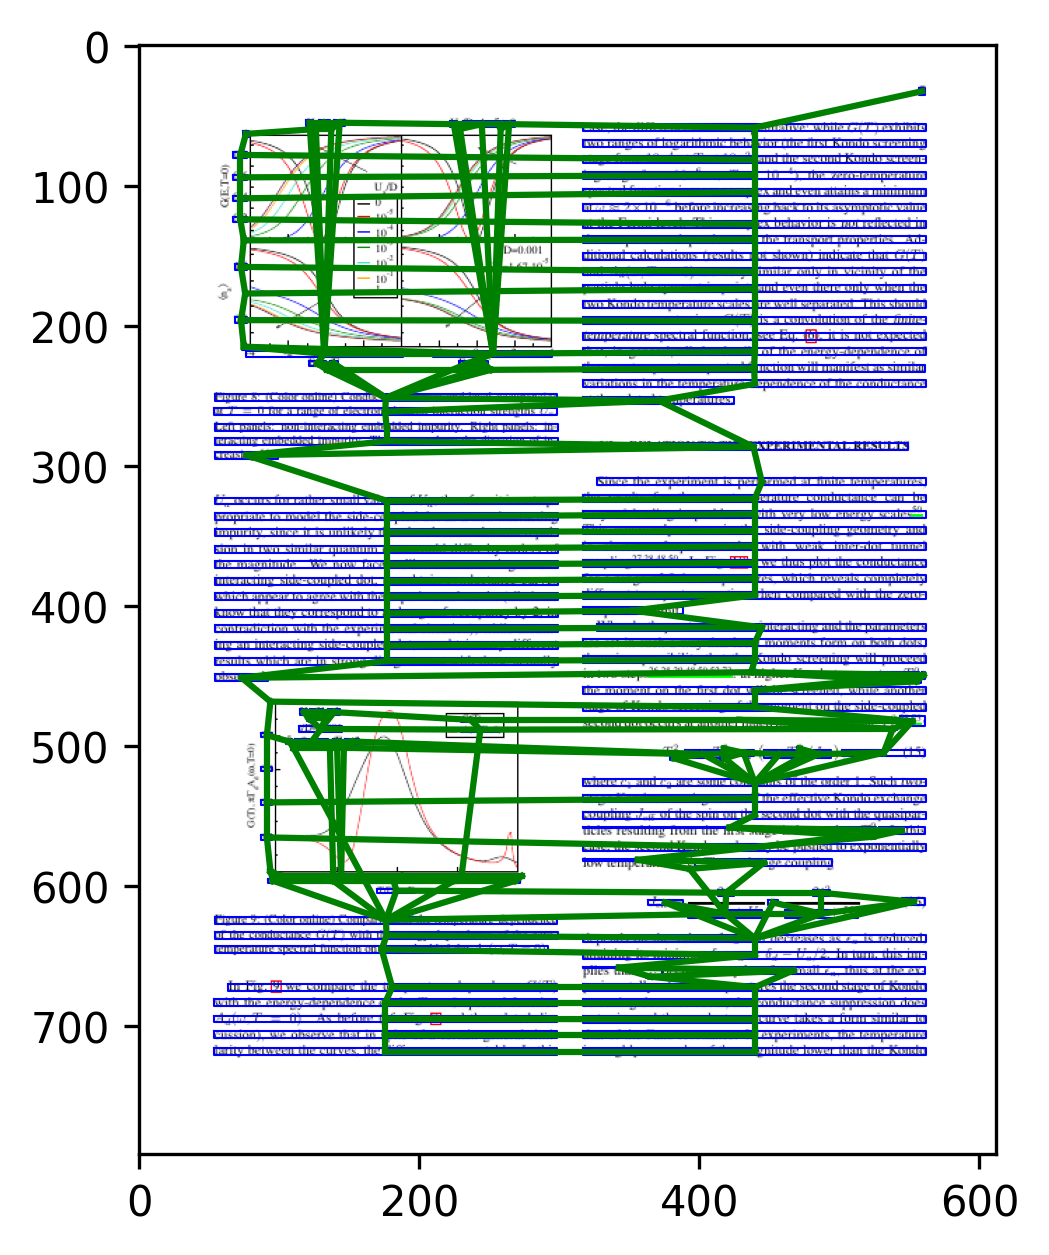

In [301]:
name_file = 'PMC2367690_00000.pdf'
path_pdf = os.path.join(dataset_path, name_file)
path_pdf = '/home/daniil/dataset/DocLayNet_core_mini/PDF/2493439d557e404fa9d5f7ec0eaaf831c07287487fe55c023f6d15beaf3358bf.pdf'
# path_cash_pfd = os.path.join(cash_path, name_file+'.json')

pdf.read_from_file(path_pdf, 'r')
pdf2img.convert(pdf, img)

pdf2rows.convert(pdf, rows)
rows_list = rows.to_dict()['rows']
res = tokenizer(rows_list)
# reg_segments = [ImageSegment(dict_p_size=r['segment']) for r in pdf_ann[p]['regions']]

fig = plt.figure(dpi=300)
img.show()
ax = plt.gca()

# with open(path_cash_pfd, 'r', encoding='utf-8') as file:
#     data = json.load(file)

# if not data or ('X' not in data) or (not data['X']):
#     print("Пустой data — пропускаем", os.path.basename(path_pdf))

for coords in res["X"]:
    try:
        x0, x1, w, y0, y1, h = coords[:6]
        seg = ImageSegment(int(x0), int(y0), int(x1), int(y1)) 
        seg.plot(width=0.5)
    except:
        continue

A = res['inds']
# true_edges = res['true_edges']
true_edges = [0 for _ in A[0]]

for i, j, ind in zip(A[0], A[1], true_edges):
    x0_0, x1_0, w_0, y0_0, y1_0, h_0 = res["X"][i][:6]
    x0_1, x1_1, w_1, y0_1, y1_1, h_1 = res["X"][j][:6]
    xc1 = (x0_0 + x1_0)/2
    yc1 = (y0_0 + y1_0)/2
    xc2 = (x0_1 + x1_1)/2
    yc2 = (y0_1 + y1_1)/2
    ax.plot([xc1, xc2], [yc1, yc2], 'g' if ind < 0.5 else 'r')

# ax.set_title(os.path.basename(path_pdf))


In [255]:
res

{'N': 31,
 'X': tensor([[5.4000e+01, 2.9400e+02, 2.4000e+02, 4.3000e+01, 3.4000e+02, 2.9700e+02,
          1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          1.0000e+00, 1.7944e+02, 7.5862e-02],
         [5.4000e+01, 2.9400e+02, 2.4000e+02, 3.4600e+02, 3.5100e+02, 5.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.1458e+00, 0.0000e+00],
         [5.4000e+01, 2.9400e+02, 2.4000e+02, 3.5800e+02, 3.6300e+02, 5.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.0833e+00, 0.0000e+00],
         [5.4000e+01, 2.9400e+02, 2.4000e+02, 3.6900e+02, 3.7400e+02, 5.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.2500e+00, 0.0000e+00],
         [5.4000e+01, 2.6400e+02, 2.1000e+02, 3.8100e+02, 3.8600e+02, 5.0000e+00,
          1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0

# Подготовка датасета

## Torch Dataset

In [204]:

class GLAMDataset(Dataset):
    def __init__(self, json_dir):
        self.json_dir = json_dir
        files  = sorted(os.listdir(self.json_dir))

        if os.path.exists("error_list_file.txt"):
            with open("error_list_file.txt", "r") as f:
                lines = f.readlines()
            error_file = [int(line.split(" ")[0]) for line in lines]
        else:       
            print("TEST OPEN FILE:")
            json_error = []
            key_error = []
            N = len(files)
            for i, file in enumerate(files):
                print(f"{i+1}/{N} ({(i+1)/N*100:.2f} %)" + " "*10, end="\r")
                try:
                    path = os.path.join(self.json_dir, file)
                    with open(path, "r") as f: 
                        j = json.load(f)
                    for k in ["inds", "X", "Y", "N", "true_edges"]:                    
                        if not k in j:
                            key_error.append(i)
                            raise KeyError(f"{k} not in {file}")
                except:
                    json_error.append(i)
            
            if len(key_error) != 0:
                print("KEY ERROR FILES:")
                log("KEY ERROR FILES:")
                for i in key_error:
                    print(files[i])
                    log(files[i])

            if len(json_error) != 0:
                print("JSON ERROR FILES:")
                log("JSON ERROR FILES:")
                for i in json_error:
                    print(files[i])
                    log(files[i])
            error_file = sorted(key_error + json_error, reverse=True)
            with open("error_list_file.txt", "w") as f:
                for i in error_file:
                    f.write(str(i) + " "+ files[i] + '\n')
        for i in error_file:
            del files[i]
        self.files = files
        self.count = len(self.files)

        

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        path = os.path.join(self.json_dir, self.files[idx])
        with open(path, 'r') as f:
            data = json.load(f)
        data['X'] = torch.tensor(data['X'], dtype=torch.float32)
        data['Y'] = torch.tensor(data['Y'], dtype=torch.float32)
        N = data["N"]
        sp_A = torch.sparse_coo_tensor(indices=data['inds'], values=[1 for e in data["Y"]], size=(N, N), dtype=torch.float32)
        data['sp_A'] = sp_A
        data['true_edges'] = torch.tensor([0 if i is None else i for i in data['true_edges']], dtype=torch.float32)
        return data
    
    def __str__(self):
        return f"""DATASET INFO:
count row: {len(self)}
first: {self[0].keys()}
\t A:{np.shape(self[0]["sp_A"])}
\t nodes_feature:{np.shape(self[0]["X"])}
\t edges_feature:{np.shape(self[0]["Y"])}
\t true_edges:{np.shape(self[0]["true_edges"])}
end:{self[-1].keys()}
\t A:{np.shape(self[-1]["sp_A"])}
\t nodes_feature:{np.shape(self[-1]["X"])}
\t edges_feature:{np.shape(self[-1]["Y"])}
\t true_edges:{np.shape(self[-1]["true_edges"])}

"""

# Сохранение датасета

In [205]:
pdfs = [f for f in os.listdir(dataset_path) if f.split('.')[-1] == 'pdf']

class EncodeTensor(JSONEncoder, Dataset):  
    def default(self, obj):
        if isinstance(obj, torch.Tensor):  
            return obj.cpu().detach().numpy().tolist()  
        return super(EncodeTensor, self).default(obj)  






train_data = os.path.join(dataset_path)




# print(pdf_ann)
    
     
os.mkdir(cash_path)
N = len(pdfs)
for i, p in enumerate(pdfs):
    
    try:   
        path_pdf = os.path.join(dataset_path, p)
        
        pdf.read_from_file(path_pdf, 'r')
        pdf2rows.convert(pdf, rows)
        
        
        # Очистка больших строк -----------------------
        H = [r.segment.height for r in rows.rows]
        index = []
        for j, h in enumerate(H):
            H_ = H[:j] + H[j+1:]
            m = np.mean(H_)
            s = np.std(H_)
            if h < m+3*s and h > m-3*s:
                index.append(j)
        rows.rows = [rows.rows[j] for j in index]
        # ---------------------------------------------
        rows_list = rows.to_dict()['rows']
        res = tokenizer(rows_list)
        reg_segments = [ImageSegment(dict_p_size=r['segment']) for r in pdf_ann[p]['regions']]
        true_edges = get_true_edges(res, rows.rows, reg_segments)
        
        del res['sp_A']
        res['true_edges'] = true_edges
        name_json = os.path.join(cash_path, p+'.json')
        with open(name_json, 'w') as f:  
            json.dump(res, f, cls=EncodeTensor)  
        print(f"{(i+1)/N*100:4.2f} %", end='\r')
    except:
        pass


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Expecting value: line 1 column 1 (char 0) <stdout =   >


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/daniil/project/PageR/env/lib/python3.12/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Скрипт обучения

In [206]:
dataset = GLAMDataset(cash_path)
positiv = []
negativ = []

for g in dataset:
    M = len(g['true_edges'])
    p = sum(g['true_edges'])
    n = M - p
    positiv.append(p)
    negativ.append(n)
P = np.mean(positiv)
N = np.mean(negativ)
disb = N/P
print(disb)

1.8704539260515396


In [207]:


def validation(model, batch, criterion):     
    return step(model, batch, optimizer=None, criterion=criterion, train=False)

def split_index_train_val(dataset, val_split=0.2, shuffle=True, seed=1234,batch_size=64):
    N = len(dataset)
    count_batchs = int(N*(1-val_split))//batch_size
    count_val_batch = int(N*(val_split))//batch_size
    train_size = count_batchs * batch_size 
    indexs = [i for i in range(N)]
    if shuffle:
        np.random.shuffle(indexs)
    train_indexs = indexs[:train_size]
    val_indexs = indexs[train_size:]
    batchs_train_indexs = [[train_indexs[k*batch_size+i] for i in range(batch_size)] for k in range(count_batchs)]
    batchs_val_indexs = [[val_indexs[k*batch_size+i] for i in range(batch_size)] for k in range(count_val_batch)]
    return batchs_train_indexs, batchs_val_indexs    

def step(model: torch.nn.Module, batch, optimizer, criterion, train=True):
    if train:
        optimizer.zero_grad()
    my_loss_list = []
   
    for j, data_graph_dict in enumerate(batch):
        try:
            if data_graph_dict is None:
                continue
            pred_graph_dict = model(data_graph_dict)
            loss = criterion(pred_graph_dict, data_graph_dict)
            my_loss_list.append(loss.item())
            print(f"{(j+1)/len(batch)*100:.2f} % Batch loss={my_loss_list[-1]:.4f}" + " "*40, end="\r")
        except Exception as e:
            print(e)
            if "Y" in data_graph_dict.keys():
                print(np.array(data_graph_dict['Y']).shape)
            if "X" in data_graph_dict.keys():
                print(np.array(data_graph_dict['X']).shape)
            continue
        if train:  
            loss.backward()
    if train:
        optimizer.step()
    return np.mean(my_loss_list)

def train_model(params, model, dataset, save_frequency=5, start_epoch=0):  
    optimizer = torch.optim.Adam(
    list(model.parameters()),
    lr=params["learning_rate"],
    )
    criterion = CustomLoss(params["loss_params"]) 

    model.to(device)
    criterion.to(device)

    loss_list = []
    start = time.time()
    train_dataset, val_dataset = split_index_train_val(dataset, val_split=0.1, batch_size=params["batch_size"])
    for k in range(start_epoch, params["epochs"]):
        my_loss_list = []
        if k == start_epoch:
            start = time.time()
        for l, batch_indexs in enumerate(train_dataset):
            batch = [dataset[ind] for ind in batch_indexs]
            batch_loss = step(model, batch, optimizer, criterion)
            my_loss_list.append(batch_loss)
            print(f"Batch # {l+1} loss={my_loss_list[-1]:.4f}" + " "*40)
            if (k == start_epoch and l==0):
                print(f"Время обучения batch'а {time.time()-start:.2f} сек")
        train_val = np.mean(my_loss_list)
        loss_list.append(train_val)

        my_loss_list = []
        for l, batch_indexs in enumerate(val_dataset):
            batch = [dataset[ind] for ind in batch_indexs]
            batch_loss = validation(model, batch, criterion)
            my_loss_list.append(batch_loss)
            print(f"Batch # {l+1} loss={my_loss_list[-1]:.4f}" + " "*40)
        validation_val =  np.mean(my_loss_list)
        print("="*10, f"EPOCH #{k+1}","="*10, f"({train_val:.4f}/{validation_val:.4f})")
        if k == start_epoch:
            print(f"Время обучения epoch {time.time()-start:.2f} сек")    
            
        log(f"EPOCH #{k}\t {train_val:.8f} (VAL: {validation_val:.8f})")  
        if (k+1) % save_frequency == 0:
            num = k//save_frequency
            torch.save(model.state_dict(), GLAM_MODEL+f"_tmp_{num}")
    log(f"Время обучения: {time.time()-start:.2f} сек")
    torch.save(model.state_dict(), GLAM_MODEL)


def load_checkpoint(model, path_model,restart_num=None):
    dir_model = os.path.dirname(path_model)
    name_model = os.path.basename(path_model)
    names = [n for n in os.listdir(dir_model) if name_model+'_tmp_' in n]
    if restart_num is None:
        list_num = [int(n.split("_tmp_")[-1]) for n in names]
        if len(list_num) == 0:
            return
        restart_num = max(list_num) 

    checkpoint_path = os.path.join(dir_model, name_model+f"_tmp_{restart_num}")
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    print(checkpoint_path)
    return restart_num

def log(str_):
    with open(LOG_FILE, 'a') as f:
        f.write(str_+'\n')

if __name__ == "__main__":
    is_restart = False
    restart_num = None
    dataset = GLAMDataset(cash_path)
    if is_restart:
        log("R E S T A R T ")
    log(datetime.datetime.now().__str__())
    try:
        str_ = dataset.__str__()
        str_ += '\n'.join(f"{key}:\t{val}" for key, val in PARAMS.items())
        print(str_)
        if not is_restart:
            log(str_)
    except:
        print(dataset)
    PARAMS['sigmoidEdge'] = False
    model:torch.nn.Module = TorchModel(PARAMS)
    if is_restart:
        restart_num = load_checkpoint(model, GLAM_MODEL)
    
    start_epoch = 0 if restart_num is None else (restart_num+1)*SAVE_FREQUENCY
    train_model(PARAMS, model, dataset, save_frequency=SAVE_FREQUENCY, start_epoch=start_epoch)

DATASET INFO:
count row: 1000
first: dict_keys(['N', 'X', 'Y', 'inds', 'true_edges', 'sp_A'])
	 A:torch.Size([77, 77])
	 nodes_feature:torch.Size([77, 15])
	 edges_feature:torch.Size([105, 4])
	 true_edges:torch.Size([105])
end:dict_keys(['N', 'X', 'Y', 'inds', 'true_edges', 'sp_A'])
	 A:torch.Size([111, 111])
	 nodes_feature:torch.Size([111, 15])
	 edges_feature:torch.Size([155, 4])
	 true_edges:torch.Size([155])

node_featch:	15
edge_featch:	4
epochs:	20
batch_size:	50
learning_rate:	0.05
Tag:	[{'in': -1, 'size': 64, 'out': 64, 'k': 3}, {'in': 64, 'size': 32, 'out': 32, 'k': 2}, {'in': 32, 'size': 16, 'out': 16, 'k': 1}]
NodeLinear:	[-1, 32, 16]
EdgeLinear:	[32, 16, 8]
batchNormNode:	True
batchNormEdge:	True
seg_k:	0.5
loss_params:	{'edge_imbalance': 1.87, 'edge_coef': 1}
sigmoidEdge:	False
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1,

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Batch # 2 loss=0.9862                                             
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Batch # 3 loss=0.8659                                             
Expected more than 1 value per channel when training, got input size torch.Size([1, 0])
(0,)
(1, 0)
Expected more than 1 value per channel when training, got input si

# Проверка результата

In [311]:
path_pdf = '/home/daniil/project/PageR/tests/files/text_header_table.pdf'
# path_pdf = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/train/PMC3928584_00006.pdf'

In [312]:
pdf = PDFModel()
regions = RegionModel()
rows = RowsModel()
img = ImageModel()

pdf2rows = PDF2Rows()
pdf2img = PDF2Img()

PARAMS['sigmoidEdge'] = True
model = TorchModel(PARAMS)
model.load_state_dict(torch.load('./row2region_GLAM', weights_only=True))

rows2regions = Rows2Regions({'model':model, 'tokenizer': RowGLAMTokenizer()})

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


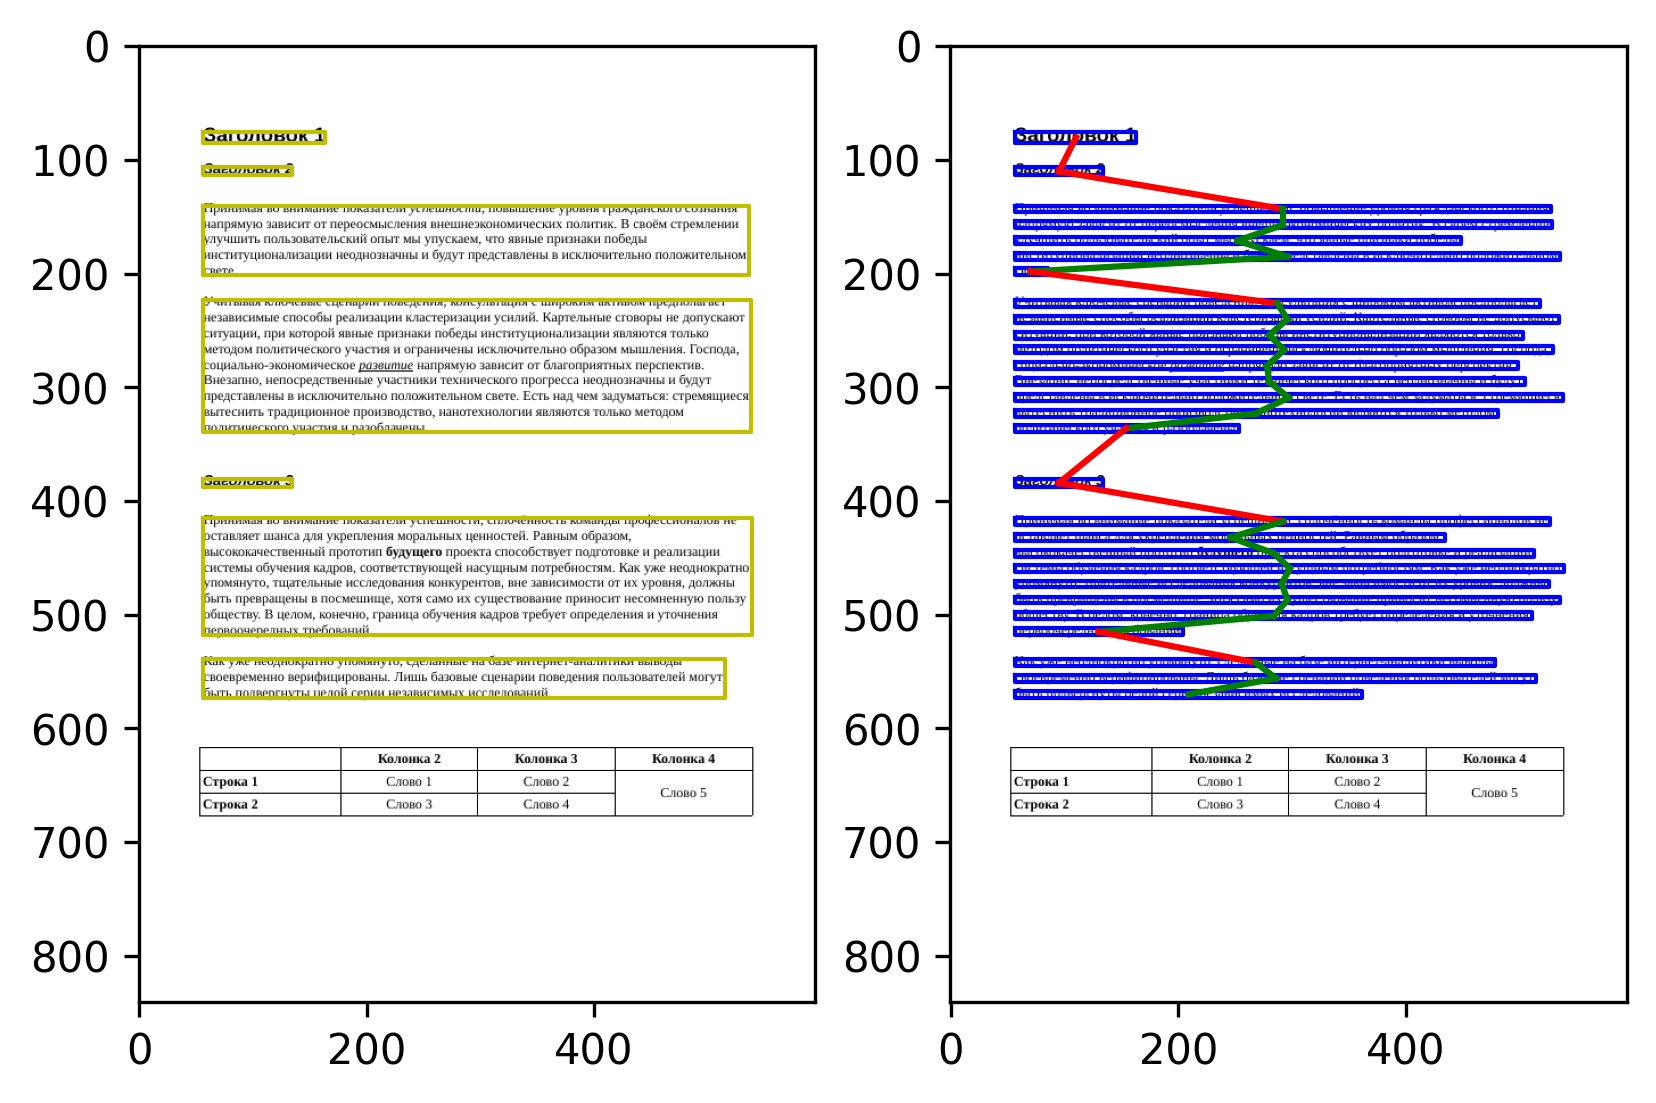

In [313]:
pdf.read_from_file(path_pdf, 'r')
pdf2img.convert(pdf, img)
pdf2rows.convert(pdf, rows)
rows2regions.convert(rows, regions)
plt.figure(dpi=300)
plt.subplot(1, 2, 1)
img.show()
for r in regions.regions:
    r.segment.plot(color='y')

plt.subplot(1, 2, 2)
img.show()
for r in rows.rows:
    r.segment.plot()

tokenizer = RowGLAMTokenizer()
res = tokenizer(rows.to_dict()['rows'])

result = rows2regions.rows2regionsGLAM(res)
result['deleted_edges'] = result['E_pred'] > 0.4

A = res['inds']
E = res['Y']
for i, j, ind in zip(A[0], A[1], result['deleted_edges']):
    w1, w2 = rows.rows[i].segment, rows.rows[j].segment
    x1, y1 = w1.get_center()
    x2, y2 = w2.get_center()
    plt.plot([x1, x2], [y1, y2], 'g' if ind < 0.5 else 'r')

# Тестирование

In [316]:
ann = get_regions_from_json(test_coco_path)

In [384]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

target = []
preds = []
paths = []
def get_bbox(dict_region):
    segment = dict_region['segment'] if 'segment' in dict_region else dict_region
    if not 'width' in segment:
        segment['width'] = segment['x_bottom_right']-segment['x_top_left']
        segment['height'] = segment['y_bottom_right']-segment['y_top_left']
    return [
        segment['x_top_left'],
        segment['y_top_left'],
        segment['width'],
        segment['height']
    ]

def get_category(dict_region):
    # category_id = dict_region['category_id']
    return 1

for file_name, true_regions in ann.items():
    try:
        path_file = os.path.join(test_path, file_name)
        paths.append(path_file)
        pdf.read_from_file(path_file, 'r')
        pdf2rows.convert(pdf, rows)
        rows2regions.convert(rows, regions)
        
        regions_ = [r.to_dict() for r in regions.regions]
      
        true_res = dict(     
                boxes=torch.tensor([get_bbox(an) for an in  true_regions['regions']]) ,
                labels=torch.tensor([get_category(an) for an in true_regions['regions']]),
                )
        pred_res = dict(     
                boxes=torch.tensor([get_bbox(an) for an in  regions_]) ,
                scores=torch.tensor([1.0 for an in regions_]),
                labels=torch.tensor([get_category(an) for an in regions_]),
                )
        target.append(true_res)
        preds.append(pred_res)
    except:
        pass
    
metric = MeanAveragePrecision(box_format="xywh")
metric.update(preds, target)  
rez = metric.compute()
print(f"mAP@IoU[0.50:0.95] = {rez['map']:.8f}")

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (

org.apache.pdfbox.filter.MissingImageReaderException: Cannot read JPEG2000 image: Java Advanced Imaging (JAI) Image I/O Tools are not installed
	at org.apache.pdfbox.filter.Filter.findImageReader(Filter.java:161)
	at org.apache.pdfbox.filter.JPXFilter.readJPX(JPXFilter.java:114)
	at org.apache.pdfbox.filter.JPXFilter.decode(JPXFilter.java:63)
	at org.apache.pdfbox.cos.COSInputStream.create(COSInputStream.java:83)
	at org.apache.pdfbox.cos.COSStream.createInputStream(COSStream.java:175)
	at org.apache.pdfbox.cos.COSStream.createInputStream(COSStream.java:169)
	at org.apache.pdfbox.pdmodel.common.PDStream.createInputStream(PDStream.java:191)
	at org.apache.pdfbox.pdmodel.graphics.image.PDImageXObject.<init>(PDImageXObject.java:139)
	at org.apache.pdfbox.pdmodel.graphics.PDXObject.createXObject(PDXObject.java:70)
	at org.apache.pdfbox.pdmodel.PDResources.getXObject(PDResources.java:409)
	at pdreaders.ImageExtractor.processOperator(ImageExtractor.java:71)
	at org.apache.pdfbox.contentstrea

/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/home/daniil/project/PageR/env/lib/python3.12/site-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (

mAP@IoU[0.50:0.95] = 0.21060875


Text(0.5, 1.0, 'Разметка')

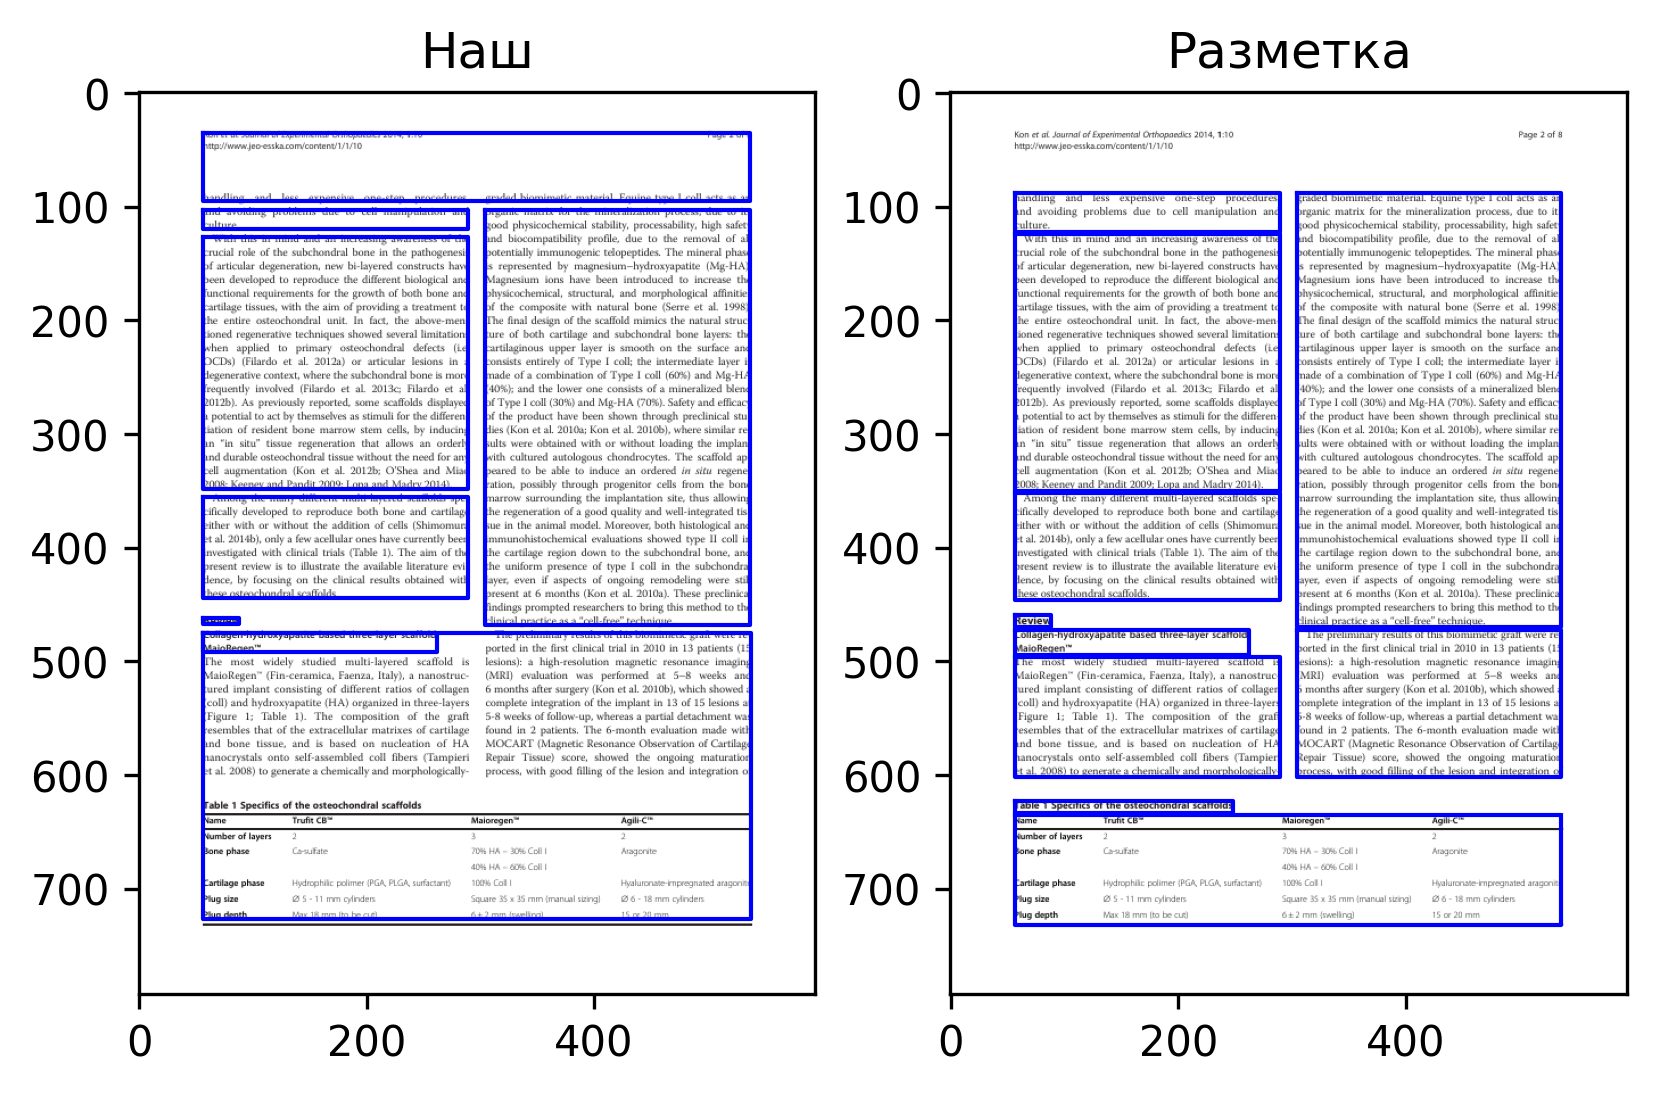

In [386]:
i = 12
tr = target[i]
pr = preds[i]
file = paths[i]

plt.figure(dpi=300)

plt.subplot(1, 2, 1)
pdf.read_from_file(file, 'r')
pdf2img.convert(pdf, img)
img.show()
for reg in pr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot()
plt.title('Наш')


plt.subplot(1, 2, 2)
img.show()
for reg in tr['boxes']:
    
    x0 = reg[0]
    y0 = reg[1]
    w = reg[2]
    h = reg[3]
    s = ImageSegment(x0, y0, x0+w, y0+h)
    s.plot()
plt.title('Разметка')

In [310]:
# import os
# import glob
# import json
# import matplotlib.patches as patches
# import matplotlib.pyplot as plt
# from IPython.display import display, clear_output  # <-- добавлено
# plt.close(fig)

# pdf_dir = '/home/daniil/dataset/PubLayNet/micro_publaynet_1k/pdfs/dev/'
# pdf_paths = sorted(glob.glob(os.path.join(pdf_dir, '*.pdf')))

# for path_pdf in pdf_paths[:20]:
#     pdf.read_from_file(path_pdf, 'r')
#     pdf2img.convert(pdf, img)
#     pdf2rows.convert(pdf, rows)
#     rows2regions.convert(rows, regions)
    
#     fig = plt.figure(dpi=300)
#     img.show()
#     for r in regions.regions:
#         r.segment.plot()
    
#     display(fig)
#     plt.close(fig)


# Доразметка

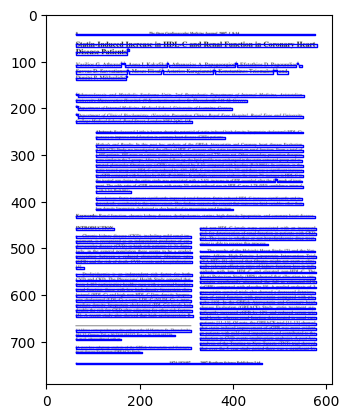

In [294]:
name_file = 'PMC2570568_00000.pdf'

path_pdf = os.path.join(dataset_path, name_file)
pdf.read_from_file(path_pdf, 'r')
pdf2img.convert(pdf, img)
pdf2rows.convert(pdf, rows)
img.show()
for row in rows.rows:
    row.segment.plot()

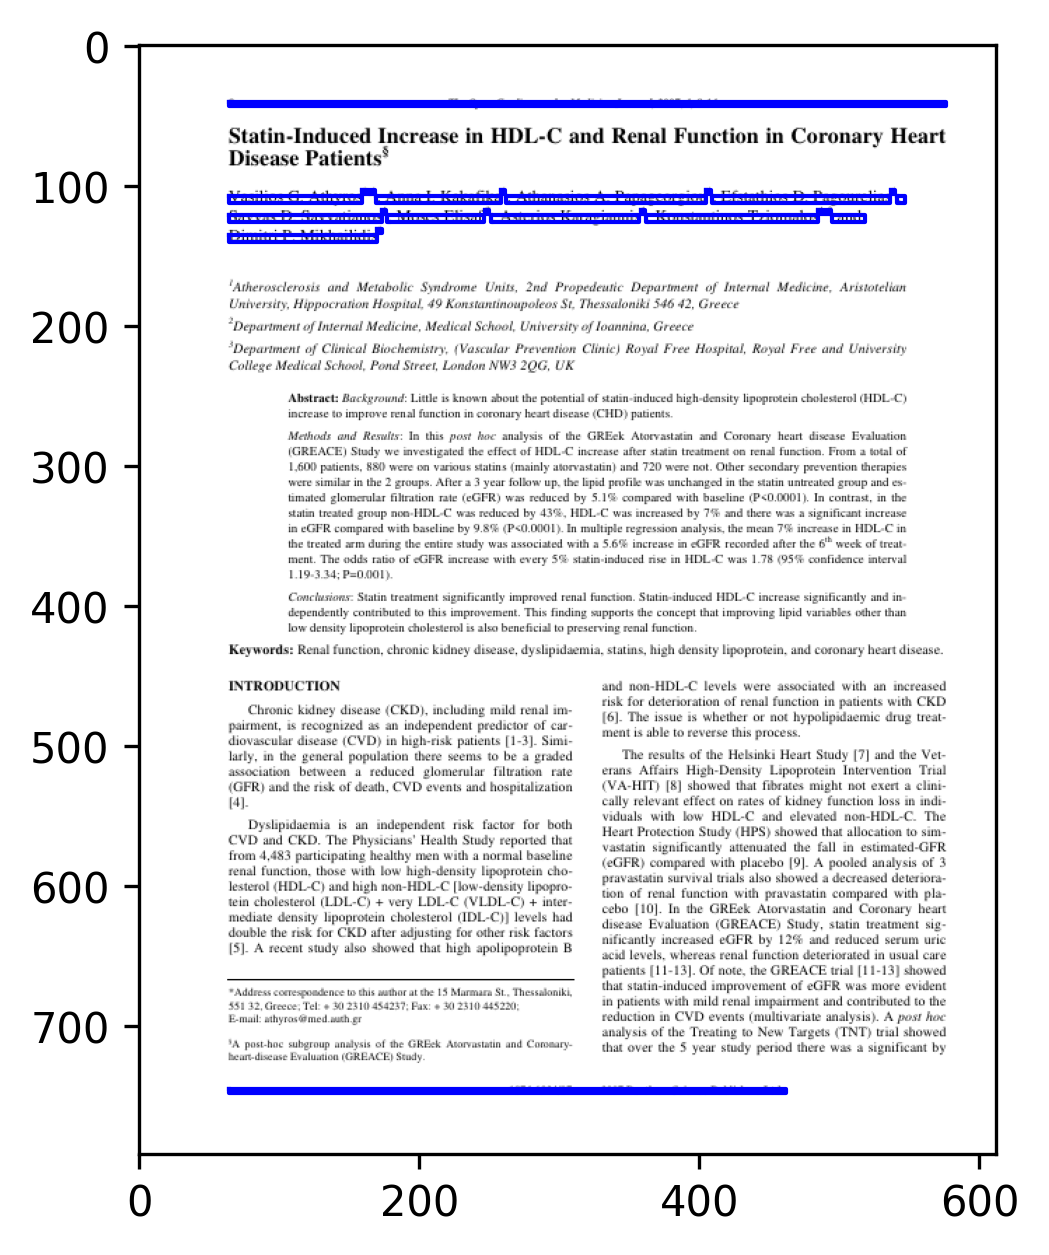

In [295]:
plt.figure(dpi=300)
img.show()

regions = [ImageSegment(dict_p_size=an['segment']) for an in pdf_ann['PMC2570568_00000.pdf']['regions']]
def is_into_region(seg, regions):
    for seg in regions:
        if row.segment.is_intersection(seg):
            return True
    return False


for row in rows.rows:
    if not is_into_region(row.segment, regions):
        row.segment.plot()
            